<a href="https://colab.research.google.com/github/tejaswiniR161/fewLeetCodeSolutions/blob/master/CI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import random
import pickle

In [ ]:
local_zip = '/content/Dataset.zip' #/content/Dataset.zip
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/")
zip_ref.close()

In [ ]:
img_size=224

data=[]

In [ ]:
#reading all images and appending into an array
def reshape_imgs():
    for directory in ["closed_eyes","open_eyes"]:
        relative_path=os.path.join("/Dataset/",directory)
        index=["closed_eyes","open_eyes"].index(directory)
        for img in os.listdir(relative_path):
            img_path=os.path.join(relative_path,img)
            try:
                img_gray=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
                img_rgb=cv2.cvtColor(img_gray,cv2.COLOR_GRAY2RGB)
                #img_rgb=cv2.imread(img_path,cv2.COLOR_GRAY2RGB)
                img_resized=cv2.resize(img_rgb,(img_size,img_size))
                data.append([img_resized,index])
            except Exception as e:
                #print(str(e))
                pass

In [ ]:
reshape_imgs()
#/Dataset/closed_eyes

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [ ]:
#shuffling to reorder 0th and 1st indexes so they don't appear in the same queue
random.shuffle(data)

eyes=[]
labels=[]

for eye,label in data:
    eyes.append(eye)
    labels.append(label)

EYES=np.array(eyes).reshape(-1,img_size,img_size,3)

#normalizing in the easiest possible way
EYES=EYES/255.0
LABELS=np.array(labels)

In [ ]:
pickle_eyes=open("eyes.pickle","wb")
pickle.dump(EYES,pickle_eyes)
pickle_eyes.close()

pickle_labels=open("labels.pickle","wb")
pickle.dump(LABELS,pickle_labels)
pickle_labels.close()

pickle_in=open("eyes.pickle","rb")
EYES=pickle.load(pickle_in)

pickle_in=open("labels.pickle","rb")
LABELS=pickle.load(pickle_in)

In [ ]:
model=tf.keras.applications.mobilenet.MobileNet()
print("model summary = ",model.summary())

17227776/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [ ]:
base_ip=model.layers[0].input
base_op=model.layers[-4].output

flat_base_layer=layers.Flatten()(base_op)
fin_op=layers.Dense(1)(flat_base_layer)
fin_op=layers.Activation("sigmoid")(fin_op)

new_model=keras.Model(inputs=base_ip,outputs=fin_op)
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [ ]:
new_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
new_model.fit(EYES,LABELS,epochs=1,validation_split=0.2)

new_model.save("my_model.h5")

82/82 [==============================] - 497s 6s/step - loss: 0.0245 - accuracy: 0.9923 - val_loss: 0.1981 - val_accuracy: 0.9615


In [ ]:
saved_model=tf.keras.models.load_model("my_model_20_e.h5")

In [ ]:
local_zip = '/content/Test_Dataset.zip' #/content/Test_Dataset.zip
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/")
zip_ref.close()

In [17]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def capture(filename='source.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [22]:
saved_model=tf.keras.models.load_model("my_model_20_e.h5")

In [34]:
face = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
left_eye = cv2.CascadeClassifier('haarcascade_lefteye_2splits.xml')
right_eye = cv2.CascadeClassifier('haarcascade_righteye_2splits.xml')
eyes_both=cv2.CascadeClassifier('haarcascade_eye.xml')

(1, 244, 244, 3)
p =  [[0.9999596]]
(1, 244, 244, 3)
p =  [[0.9998681]]


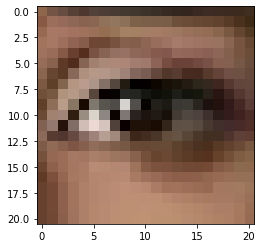

In [39]:
img = cv2.imread('sw.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eyes = eyes_both.detectMultiScale(gray,1.1,4)
for(x,y,w,h) in eyes:
  points_gray=gray[y:y+h,x:x+w]
  points_color=img[y:y+h,x:x+w]
  both=eyes_both.detectMultiScale(points_gray)
  if len(both)==0:
    print("No Face and Eyes Detected")
  else:
    for(ex,ey,ew,eh) in both:
      eyes_area=points_color[ey:ey+eh,ex:ex+ew]
      #cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
      plt.imshow(cv2.cvtColor(eyes_area, cv2.COLOR_BGR2RGB))

      fin=cv2.resize(eyes_area,(244,244))
      fin=np.expand_dims(fin,axis=0)
      fin=fin/255.0

      print(fin.shape)
      p=saved_model.predict(fin)
      print("p = ",p)


In [30]:
img = cv2.imread('Obama.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces_in_img = face.detectMultiScale(gray,minNeighbors=5,scaleFactor=1.1,minSize=(25,25))
left_eye_in_img = left_eye.detectMultiScale(gray)
right_eye_in_img =  right_eye.detectMultiScale(gray)

for (x,y,w,h) in faces_in_img:
        cv2.rectangle(img, (x,y) , (x+w,y+h) , (100,100,100) , 1 )

for (x,y,w,h) in right_eye_in_img:
        r_eye=img[y:y+h,x:x+w]

        r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
        r_eye = cv2.resize(r_eye,(img_size,img_size))
        r_eye= r_eye/255
        r_eye=  r_eye.reshape(img_size,img_size,-1)
        r_eye = np.expand_dims(r_eye,axis=0)
        r_eye.shape
        #rpred = model.predict_classes(r_eye)

        #r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
        #r_eye = cv2.resize(r_eye,(img_size,img_size))

        #final_image = cv2.resize(r_eye, (244,244))
        #final_image = np.expand_dims(final_image, axis=0)
        #final_image = final_image/255.0
        #Predictions =  my_model.predict(final_image)
        #r_eye = np.array(r_eye).reshape(1,img_size,img_size,3)
        #r_eye= r_eye/255.0
        
        right_prediction = saved_model.predict(r_eye)
        print("Right eye prediction = ",right_prediction)
        cv2.rectangle(img, (x,y), (x+w, y+h), (255, 255, 0), 2)

for (x,y,w,h) in left_eye_in_img:
        l_eye=img[y:y+h,x:x+w]
        cv2.rectangle(img, (x,y), (x+w, y+h), (255, 255, 225), 2)

#eyes = eyeCascade.detectMultiScale(gray,1.1,4)
#for(x,y,w,h) in eyes:
  #cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ValueError: ignored

In [19]:
from IPython.display import Image
try:
  filename = capture()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

'NoneType' object has no attribute 'split'


#Eyes detection from video


In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
if not cap.isOpened():
  cap = cv2.VideoCapture(0)
else:
  raise IOError('Cannot open webcam')
while True:
  ret, frame = cap.read()
  eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  eyes = eyeCascade.detectMultiScale(gray, 1.1, 4)
  for(x,y,w,h) in eyes:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x+y), (x+w,y+h), (0, 255, 255), 2)
    eyesmark = eyeCascade.detectMultiScale(roi_gray)
    if len(eyesmark) == 0:
      print("eyes are not detected")
    else:
      for (ex, ey, ew, eh) in eyesmark:
        eyes_roi = roi_color[ey: ey+eh, ex: ex+ew]
    final_image = cv2.resize(eyes_roi, (244,244))
    final_image = np.expand_dims(final_image, axis=0)
    final_image = final_image/255.0
    Predictions =  my_model.predict(final_image)
    if (Predicitions > 0):
      status = "Open eyes"
    else:
      status = "Closed eyes"
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    print(faceCascade.empty())
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
      cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,255), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame,
                status,
                (50,50),
                font, 3,
                (0, 0, 255),
                2,
                cv2.LINE_4)
    cv2.imshow('Drowsiness Detection tutorial', frame)
    if cv2.waitkey(2) & 0xFF == ord('q'):
      break
  cap.release()
  cv2.destroyAllWindows()

NameError: ignored

# If eyes are closed for unusual time, like more than blinks, for few seconds, alarm generated

In [ ]:
import winsound
frequency = 2500 # 2500 Hertz
duration = 1000 # 1sec
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
if not cap.isOpened():
  cap = cv2.VideoCapture(0)
else:
  raise IOError('Cannot open webcam')
while True:
  ret, frame = cap.read()
  eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  eyes = eyeCascade.detectMultiScale(gray, 1.1, 4)
  for(x,y,w,h) in eyes:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x+y), (x+w,y+h), (0, 255, 255), 2)
    eyesmark = eyeCascade.detectMultiScale(roi_gray)
    if len(eyesmark) == 0:
      print("eyes are not detected")
    else:
      for (ex, ey, ew, eh) in eyesmark:
        eyes_roi = roi_color[ey: ey+eh, ex: ex+ew]
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    print(faceCascade.empty())
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
      cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255, 0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX

    final_image = cv2.resize(eyes_roi, (244,244))
    final_image = np.expand_dims(final_image, axis=0)
    final_image = final_image/255.0
    
    Predictions =  my_model.predict(final_image)
    if (Predicitions > 0):
      status = "Open eyes"
      cv2.putText(frame,
                  status,
                  (150, 150),
                  font, 3,
                  (0,255,0),
                  2,
                  cv2.LIE_4)
      x1, y1, w1, h1 = 0, 0, 175, 75
      cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
    else:
      counter = counter + 1
      status = "Closed eyes"
      cv2.putText(frame,
                  status,
                  (150,150),
                  font, 3,
                  (0,0,255),
                  2,
                  cv2.LINE_4)
      cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0, 255), 2)
      if counter > 5:
        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame, (x1,x1), (x1+w1+y1+h1), (0,0,0), -1)
        cv2.putText(frame, 'Sleep Alert !!', (x1+int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        winsound.Beep(frequency, duration)
        counter = 0
    
    cv2.imshow('Drowsiness Detection tutorial', frame)
    if cv2.waitkey(2) & 0xFF == ord('q'):
      break
  cap.release()
  cv2.destroyAllWindows()

ModuleNotFoundError: ignored